## Authenticate to Colab, Cloud and GEE

In [1]:
from google.colab import drive
from google.colab import files
import sys

drive.mount('/content/gdrive/', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/Classification/USA/Yolo_2/'
model_dir = base_dir + 'models/'
IMAGES_PATH = base_dir + '/' + 'Yolo_2016_16c/'

sys.path.append(base_dir) 

Mounted at /content/gdrive/


In [ ]:
!nvidia-smi

## Import Libraries

In [2]:
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
print(tf.__version__)
import folium
print(folium.__version__)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

2.4.0
0.8.3


# Initialize global variables and functions

In [3]:
LABEL = 'landcover'


# landcovers = ['Rice', 'Alfalfa', 'Wheat', 'Sunflower', 'Safflower', 'Corn', 'YP', 'Tomatoes', 
#               'Grain and Hay', 'Grapes', 'Deciduous','Subtropical', 'Other Grass', 'Other Crops',
#               'Wetland', 'Fallowland', 'Buildup'];
landcovers = ["Rice", "Safflower", "Corn", "Other Field crops", "Alfalfa", "Other Pasture", "Cucurbits", "Tomatoes", 
             "Other Truck Crops", "Almonds and pistachios", "Other Deciduous", "Subtropical", "Vineyards", "Other"]
new_labels = tf.constant([0,4,13,3,1,2,13,6,7,8,8,8,8,8,10,3,8,8,8,13,3,8,11,10,9,9,10,12,10,10,11,11,10,10,11,8,5,10,5,8,13,13,13], dtype = tf.int32,)

nClasses = 17
r = 7

In [4]:
# new_labels = tf.constant([0,1,2,3,4,5,6,13,7,13,13,13,13,13,10,13,13,13,13,8,13,13,11,10,10,10,10,9,10,10,11,11,10,10,11,13,12,10,12,13,14,15,16], dtype = tf.int32,)
new_labels = tf.constant([0,4,13,3,1,2,13,6,7,8,8,8,8,8,10,3,8,8,8,13,3,8,11,10,9,9,10,12,10,10,11,11,10,10,11,8,5,10,5,8,13,13,13], dtype = tf.int32,)

new_labels

<tf.Tensor: shape=(43,), dtype=int32, numpy=
array([ 0,  4, 13,  3,  1,  2, 13,  6,  7,  8,  8,  8,  8,  8, 10,  3,  8,
        8,  8, 13,  3,  8, 11, 10,  9,  9, 10, 12, 10, 10, 11, 11, 10, 10,
       11,  8,  5, 10,  5,  8, 13, 13, 13], dtype=int32)>

In [5]:
train_path = IMAGES_PATH + 'training_yolo_2016_16c'
validation_path = IMAGES_PATH + 'validation_yolo_2016_16c'
test_path = IMAGES_PATH + 'testing_yolo_2016_16c'

train_file_prefix = 'training_yolo_2016'
validation_file_prefix = 'validation_yolo_2016'
test_file_prefix = 'testing_yolo_2016'

def getDatasetPaths(path, image_file_prefix):
  filesList = listdir(path = path)
  exportFilesList = [s for s in filesList if image_file_prefix in s]
  imageFilesList = []

  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f

  datasetPaths = [path + '/' + f for f in imageFilesList] 
  return datasetPaths

train_dataset_paths = getDatasetPaths(train_path, train_file_prefix)
validation_dataset_paths = getDatasetPaths(validation_path, validation_file_prefix)
test_dataset_paths = getDatasetPaths(test_path, test_file_prefix)


In [6]:
FEATURE_NAMES = []
bands =  [
          'B2', 'B3', 'B4', 'B5', 'B6','B7', 'NDVI', 'GNDVI', 'EVI', 'SAVI', 'BSI', 'NDWI', 'NDBI'
          ]

time_stamps = 9
n_features = len(bands)
for i in range(time_stamps):
  if i > 0:
    s = [b + '_' + str(i) for b in bands]
  else:
    s = bands
  FEATURE_NAMES.extend(s)
FEATURE_NAMES.append(LABEL)
# for b in bands:
#   for i in range(time_stamps):
#     if i > 0:
#       s = b + '_' + str(i)
#     else:
#       s = b
#     FEATURE_NAMES.append(s)  
  
# FEATURE_NAMES.append(LABEL)
# FEATURE_NAMES

# Data preparation and pre-processing

In [7]:
# List of fixed-length features, all of which are float32.
from pprint import pprint
import numpy as np
# z = np.zeros(91,).tolist()

columns = [
  tf.io.FixedLenSequenceFeature(shape=[r,r], dtype=tf.float32, allow_missing = True) for k in FEATURE_NAMES
]
# Dictionary with names as keys, features as values.
from collections import OrderedDict 

# featuresDict = dict(zip(FEATURE_NAMES, columns))
featuresDict = OrderedDict(zip(FEATURE_NAMES, columns))

# pprint(featuresDict)

In [8]:
# Create a dataset from the TFRecord file in Cloud Storage.
depth = len(FEATURE_NAMES)-1
def toTuple(data, label):
  
  band_values = []
  for f in FEATURE_NAMES[:-1]:
    a = tf.reshape(data[f], (7,7))[3,3]
    if f.startswith('B'):
      band_values.append(a/10000)
    else:
      band_values.append(a)

  spectral = band_values
  label = tf.gather(new_labels, label)

  return spectral, label

def parse_tfrecord(example_proto):
  parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
  labels = parsed_features.pop(LABEL)
  labels = tf.cast(labels, tf.int32)
  label = tf.math.argmax(tf.math.bincount(labels))
  return parsed_features, label

def getDataset(datasetPaths):
  dataset = tf.data.TFRecordDataset(datasetPaths, compression_type='GZIP')
  parsedDataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  inputDataset = parsedDataset.map(toTuple)
  return inputDataset

trainDataset = getDataset(train_dataset_paths)
validationDataset = getDataset(validation_dataset_paths)
testDataset = getDataset(test_dataset_paths)
alltestDataset = validationDataset.concatenate(testDataset)

In [ ]:
for data, target in trainDataset.take(5):
  print(data)
  print(target)

In [10]:
def getXY(dataset):
  X = []
  y = []
  for data, target in dataset:
    X.append(data.numpy())
    y.append(target.numpy())
  X = tf.stack(X)
  y = tf.stack(y)
  print("done")
  return X.numpy(), y.numpy()

X_train, y_train = getXY(trainDataset)
# X_valid, y_valid = getXY(validationDataset)
X_test, y_test = getXY(alltestDataset)

done
done


# RF

In [11]:
import time
t0 = time.time()
model = RandomForestClassifier(n_estimators=100, random_state=42, verbose = 2)
model.fit(X_train, y_train)
print(time.time()-t0)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.1min finished


In [16]:
print(model.score(X_test, y_test))
# print(model.score(X_valid, y_valid))
print(model.score(X_train, y_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


0.8668394025738172
1.0


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.2s finished


## Analysis

In [13]:
import pickle
filename = model_dir + 'rf5_14c.sav'
pickle.dump(model, open(filename, 'wb'))


In [ ]:
model = pickle.load(open(filename, 'rb'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.1s finished


[[13859     3     9     6     8    10     5    49     0    34    25     4
     23   346]
 [    9  2585    32    90    67     3    35   150     0     6     5     0
     15   332]
 [  127    50  1475   367     6    36    94   250     6     4     5     0
      7   214]
 [   10   156    37  5596    20    14   253   972     8    19    25     1
     23   490]
 [    1    45    30    56  9001   126    11    56     4    81    89     3
     49   470]
 [    3     1     1    17   400  3596     6    85     5    42    24     5
     28   560]
 [   12     5    11    55    10     4  1498   264    11     3    21     0
     12   172]
 [   42    19    67   105    15     1    57  9313     2    25    16     0
     18   326]
 [   21    11    25    31    28     6   197   360   490    25    31     2
     38   617]
 [    0     2     0    19    46    14     1    13     1  8087    98    44
    359  1870]
 [    1     0     0    23    96    20     5     6     0   268  4909    11
    240   513]
 [    0     0     0  

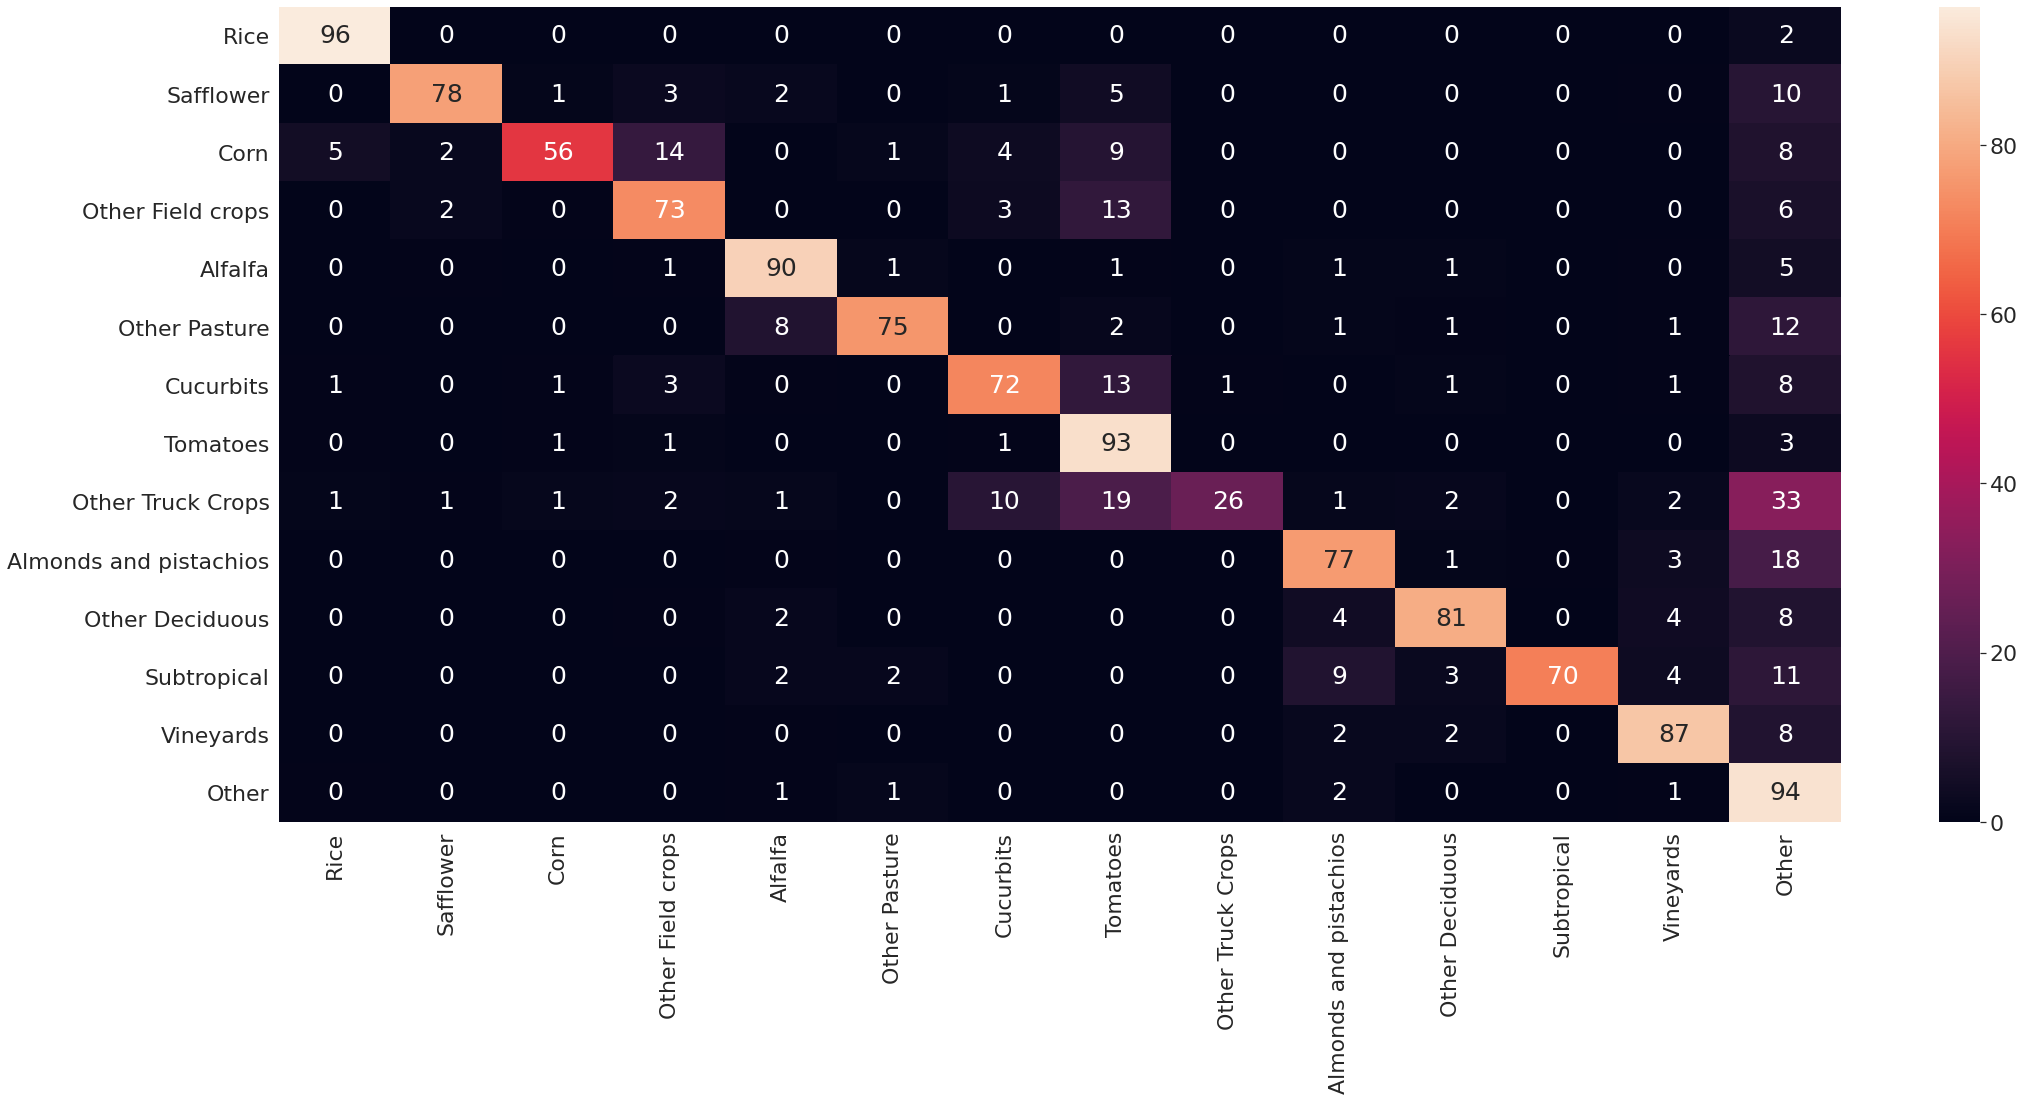

In [17]:
nClasses = 14
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test, model.predict(X_test))
print(cf)
s = np.sum(cf, axis = 1)

cf1 = pd.DataFrame(cf/(s.reshape(nClasses, 1))*100, columns=landcovers, index = landcovers)

plt.figure(figsize = (35,15))
sns.set(font_scale=2) 
sns.heatmap(cf1, annot=True, annot_kws={"size": 25},fmt = '.0f')

In [18]:
from sklearn.metrics import f1_score
f1_score(y_test, model.predict(X_test), average = 'weighted')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.1s finished


0.8625900528048303